# Final Project

## Course: Programming for Data Science
## Notebook 1: Data Exploration

### 1. Data Collection

**What subject is your data about?**
*   **Topic:** This dataset is about books from the Goodreads Choice Awards 2011-2024.
*   **Context:** It represents reader preferences, public book ratings, and author popularity within the publishing industry.

**What is the source of your data?**
*   **Platform:** Kaggle
*   **URL:** https://www.kaggle.com/datasets/krisbruurs/goodreads-choice-awards-2011-2024-books
*   **Original Author:** Kris Bruurs
*   **Collection Date:** The dataset covers the years 2011 to 2024. The specific publication date of the dataset file is not mentioned in the description.

**Is this data licensed for your use?**
*   **License:** CC0: Public Domain.
*   **Permission:** Yes, we are permitted to use it for educational purposes.
*   **Restrictions:** There are no usage restrictions or attribution requirements mentioned.

**How was this data collected?**
*   **Method:** Data is scrapped from https://www.goodreads.com/ using a python webscraped with requests and BeautifulSoup
*   **Target Population:** Books featured in the Goodreads Choice Awards across multiple genres.
*   **Time Period:** 2011 to 2024.
*   **Limitations:** No specific limitations or biases are mentioned in the description.

**Why did you choose this dataset?**
*   **Interests:** We are interested in analyzing reader trends, understanding what makes a book popular, and seeing how genres have evolved over the last decade.
*   **Potential Insights:**
    *   Understanding the relationship between author popularity (followers) and book ratings.
    *   Analyzing how pricing and reviews influence a book's success.
    *   Identifying which genres are becoming more or less popular over time.
    *   Predicting a book's commercial success or rating based on metadata.

### 2. Data Exploration

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress = True, linewidth = 120, edgeitems = 5)
sns.set_theme(style="whitegrid")

In [43]:
# 1. Load data and view structure

dataPath = "../Data/Raw/parsed_books_data.tsv"

df = pd.read_csv(dataPath, sep = "\t", na_values = ["NA"])

sampleCount, featureCount = df.shape

print(f"Total samples:    {sampleCount}")
print(f"Total features:   {featureCount}")
print("-" * 30)
print("Columns:", df.columns.tolist())

print("-" * 30)
display(df.head())


Total samples:    5283
Total features:   24
------------------------------
Columns: ['price', 'title', 'rating', 'num_ratings', 'num_reviews', 'num_pages', 'genres', 'publication_year', 'author', 'author_book_count', 'author_followers_count', 'five_star_count', 'five_star_percentage', 'four_star_count', 'four_star_percentage', 'three_star_count', 'three_star_percentage', 'two_star_count', 'two_star_percentage', 'one_star_count', 'one_star_percentage', 'votes', 'category', 'award_year']
------------------------------


,price,title,rating,num_ratings,num_reviews,num_pages,genres,publication_year,author,author_book_count,author_followers_count,five_star_count,five_star_percentage,four_star_count,four_star_percentage,three_star_count,three_star_percentage,two_star_count,two_star_percentage,one_star_count,one_star_percentage,votes,category,award_year
0,14.99,The Wedding People,4.16,327019,38667,384.0,Fiction|Romance|Audiobook|Contemporary|Literar...,2024,Alison Espach,8,2416.0,123227,37,144585,44,48565,14,8388,2,2254,0,94733,Fiction,2024
1,14.99,Intermezzo,3.93,171506,31312,454.0,Fiction|Contemporary|Literary Fiction|Romance|...,2024,Sally Rooney,43,61500.0,53605,31,68660,40,36424,21,9842,5,2975,1,67268,Fiction,2024
2,9.13,Welcome to the Hyunam-Dong Bookshop,3.97,49745,9574,307.0,Contemporary|Books About Books|Audiobook|Cozy|...,2022,Hwang Bo-Reum,3,740.0,15568,31,20267,40,11063,22,2367,4,480,0,51958,Fiction,2024
3,13.99,Blue Sisters,3.98,140226,19902,342.0,Fiction|Contemporary|Literary Fiction|Audioboo...,2024,Coco Mellors,5,5253.0,43785,31,60355,43,27337,19,7508,5,1241,0,50659,Fiction,2024
4,14.99,Here One Moment,4.05,146803,16125,512.0,Fiction|Audiobook|Mystery|Contemporary|Thrille...,2024,Liane Moriarty,42,71800.0,49893,33,62470,42,27770,18,5392,3,1278,0,48432,Fiction,2024


**Basic Information**

*   **How many rows?**
    *   5,283 rows.
*   **How many columns?**
    *   24 columns.
*   **What does each row represent?**
    *   Each row represents a single book that was nominated for or won a Goodreads Choice Award between 2011 and 2024.
*   **What is the overall size?**
    *   The dataset contains 5,283 entries across 24 features. Total data points: 126,792.

In [ ]:
zeroPriceCount = (df['price'] == 0).sum()
naPriceCount = df['price'].isna().sum()

print(f"Duplicated rows: {df.duplicated().sum()}")
print("Missing values per column:")
print("-" * 30)
missingInfo = df.isna().sum()
print(missingInfo[missingInfo > 0])
print("-" * 30)
print(f"Books with price 0:       {zeroPriceCount}")
print(f"Books with price 'NA':    {naPriceCount}")

Duplicated rows: 0
Missing values per column:
------------------------------
price                     2031
num_pages                   16
author_followers_count       5
dtype: int64
------------------------------
Books with price 0:       438
Books with price 'NA':    2031


**Data Integrity**

*   **Are there any duplicated rows?**
    *   No, there are 0 duplicated rows.
*   **Are all rows complete?**
    *   No, some rows have missing data:
        *   **Price:** Missing in 2,031 rows.
        *   **Pages:** Missing in 16 rows.
        *   **Author Followers:** Missing in 5 rows.

In [51]:
DISCRETE_THRESHOLD = 25 
TARGET_COL = ''
COLS_TO_AVOID = ['genres_list', 'binned']

col_info = {}
target_features = []
categorical_features = [] 
numerical_discrete_features = []
numerical_continuous_features = []
ignored_features = [] 

for col_name in df.columns:
    if col_name in COLS_TO_AVOID:
        continue

    unique_count = df[col_name].nunique()
    
    if col_name == TARGET_COL:
        col_type = "Target"
        target_features.append(col_name)
    
    elif pd.api.types.is_numeric_dtype(df[col_name]):
        col_type = "Numerical"
        if unique_count < DISCRETE_THRESHOLD:
            numerical_discrete_features.append(col_name)
        else:
            numerical_continuous_features.append(col_name)
            
    else:
        col_type = "Categorical"
        categorical_features.append(col_name)

    col_info[col_name] = {"Type": col_type, "UniqueCount": unique_count}

print("-" * 60)
print(f"{'Column Name':<30} | {'Type':<12} | {'Unique Vals'}")
print("-" * 60)

# Group 1: Categorical
for col in categorical_features:
    info = col_info[col]
    print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

print("-" * 60)

# Group 2: Numerical 
for col in numerical_discrete_features:
    info = col_info[col]
    print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

for col in numerical_continuous_features:
    info = col_info[col]
    print(f"{col:<30} | {info['Type']:<12} | {info['UniqueCount']}")

print("-" * 60)

print("\nSummary:")
print(f"Categorical Features:   {len(categorical_features)}")
print(f"Numerical Discrete:     {len(numerical_discrete_features)}")
print(f"Numerical Continuous:   {len(numerical_continuous_features)}")
print(f"Ignored Features:       {len(ignored_features)}")

------------------------------------------------------------
Column Name                    | Type         | Unique Vals
------------------------------------------------------------
title                          | Categorical  | 5036
genres                         | Categorical  | 4724
author                         | Categorical  | 3106
category                       | Categorical  | 31
------------------------------------------------------------
publication_year               | Numerical    | 23
two_star_percentage            | Numerical    | 22
one_star_percentage            | Numerical    | 13
award_year                     | Numerical    | 14
price                          | Numerical    | 140
rating                         | Numerical    | 155
num_ratings                    | Numerical    | 4956
num_reviews                    | Numerical    | 3952
num_pages                      | Numerical    | 668
author_book_count              | Numerical    | 343
author_followers_count       

**What is the meaning of each column?**
*   **Book Info:** `title`, `author`, `publication_year`, `num_pages`, `genres` (topics), `category` (award category), `award_year`.
*   **Financial:** `price` (Cost to buy).
*   **Engagement (Outcomes):** `num_ratings` (Reach), `num_reviews` (Discussion), `votes` (Award votes).
*   **Quality:** `rating` (Average score) and detailed Star Breakdowns (`five_star_count`, etc.).
*   **Author Stats:** `author_book_count` (Experience), `author_followers_count` (Fame).

**Which columns are relevant to analysis?**
*   **Predictors (Inputs):** `num_pages`, `publication_year`, `price`, `genres`, `category`, `author_followers_count`, `author_book_count`, `award_year`.
*   **Target (Output):** `num_ratings` (to measure commercial reach).

**Are there columns that should be dropped?**
*   **Yes, for modeling:**
    *   **Leakage Columns:** `votes`, `num_reviews`, and all detailed star counts (e.g., `five_star_count`). 
    *   **High Cardinality:** `title` and `author` (names) are too unique to be useful directly.

**What is the current data type?**
*   **Numerical:** 20 columns (e.g., `price`, `num_pages`, `rating`, `counts`...).
*   **Categorical (Object/String):** 4 columns (`title`, `genres`, `author`, `category`).

**Are there columns with inappropriate data types?**
*   **`genres`:** It is currently a single string (e.g., "Fantasy|Magic") containing multiple genres.

**Which columns need type conversion?**
*   **`genres`:** Needs to be split into lists and then converted into binary flags (e.g., `is_Fantasy`, `is_Romance`).
*   **`price`:** Needs to account for `NA` (Subscription) and `0` (Bundle) values.

In [ ]:
print(df.describe().map(lambda x: f"{x:.2f}"))

         price   rating num_ratings num_reviews num_pages publication_year author_book_count author_followers_count five_star_count five_star_percentage four_star_count four_star_percentage three_star_count three_star_percentage two_star_count two_star_percentage one_star_count one_star_percentage      votes award_year
count  3252.00  5283.00     5283.00     5283.00   5267.00          5283.00           5283.00                5278.00         5283.00              5283.00         5283.00              5283.00          5283.00               5283.00        5283.00             5283.00        5283.00             5283.00    5283.00    5283.00
mean      9.62     4.04   106418.65     9836.15    342.75          2017.04             93.18               27791.74        44009.22                36.87        37778.93                36.57         18294.97                 18.70        4591.78                4.20        1743.74                1.15   10358.62    2017.15
std       5.00     0.26   307798.65  

Number of genres: 456
   index             0
0   3199       Fiction
1   3003     Audiobook
2   1620    Nonfiction
3   1544       Fantasy
4   1312       Romance
5   1172  Contemporary
6   1050   Young Adult
7   1013         Adult
8    863       Mystery


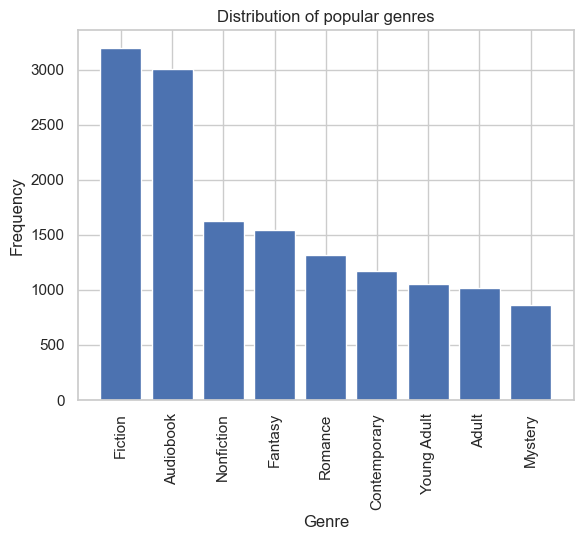

In [70]:
# 5. Genre Analysis
genres = df["genres"].str.split("|").values
genres = np.hstack(genres)
genres, frequency = np.unique(genres, return_counts=True)

print("Number of genres:", genres.size)

popular_genres = frequency.argsort()[:-10:-1]

popular_genres_df = pd.DataFrame(genres[popular_genres], frequency[popular_genres]).reset_index()

print(popular_genres_df)

fig, axes = plt.subplots()
axes.bar(genres[popular_genres], frequency[popular_genres])
axes.set_title("Distribution of popular genres")
axes.set_xlabel("Genre")
axes.set_ylabel("Frequency")
axes.tick_params(axis='x', rotation=90)
plt.show()

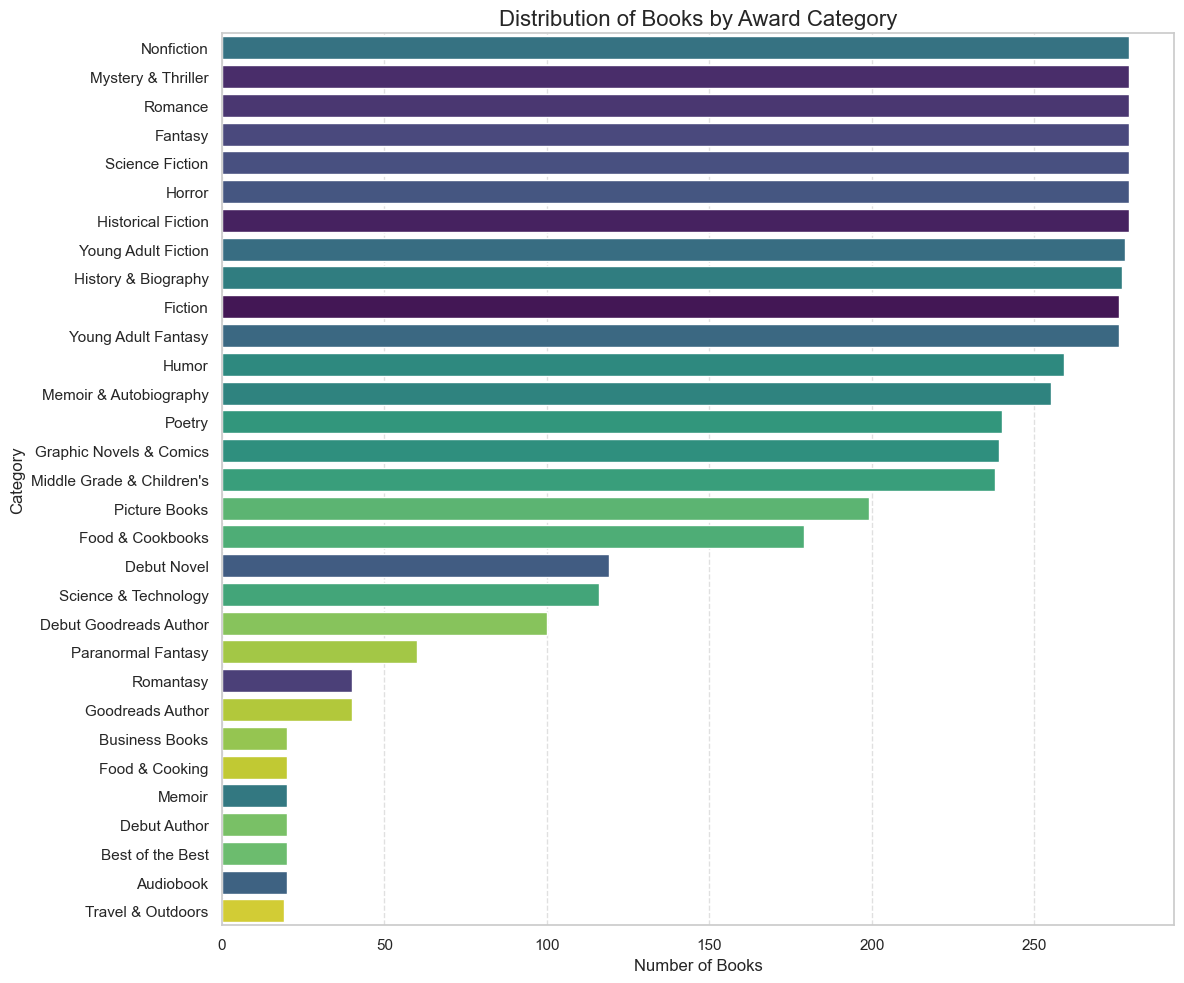

In [ ]:
plt.figure(figsize=(12, 10))

category_order = df['category'].value_counts().index

sns.countplot(
    y=df['category'], 
    order=category_order, 
    palette='viridis', 
    hue=df['category'], 
    legend=False
)

plt.title('Distribution of Award Category', fontsize=16)
plt.xlabel('Number of Books')
plt.ylabel('Category')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Value Distribution:**

*   **How many unique values?**
    *   **Genres:** 456 unique genres.
    *   **Category:** 31 unique award categories.
*   **What are the top most frequent values?**
    *   **Genres:** Fiction (3199), Audiobook (3003), Nonfiction (1620), Fantasy (1544), Romance (1312).
    *   **Category:** Nonfiction, Mystery & Thriller, Romance, Fantasy, and Science Fiction are tied for the top spots (about 275-280 books each).
*   **Is the distribution balanced?**
    *   **Genres:** **Highly Imbalanced.** The top 2 tags (Fiction, Audiobook) appear in over 50% of the dataset, while hundreds of other niche genres appear very rarely.
    *   **Category:** **Fairly Balanced** among the top 15 categories, which all have similar counts. Categories (like "Travel & Outdoors" or "Paranormal Fantasy") that have far fewer books.

**Data Quality:**

*   **Missing values:**
    *   0% missing values for `category` and `genres`.
*   **Inconsistencies:**
    *   No inconsistencies found
*   **Unexpected values:**
    *   No obvious typos or errors found.
*   **Grouping:**
    *   **Genres:** Focus on the **Top 20** for analysis and model training, and likely ignore the rest.
    *   **Category:** The bottom categories (like "Travel" or "Business") have small samples (<50). For some analyses, these might need to be grouped into "Other Nonfiction."


Numerical Feature Distributions and Outliers


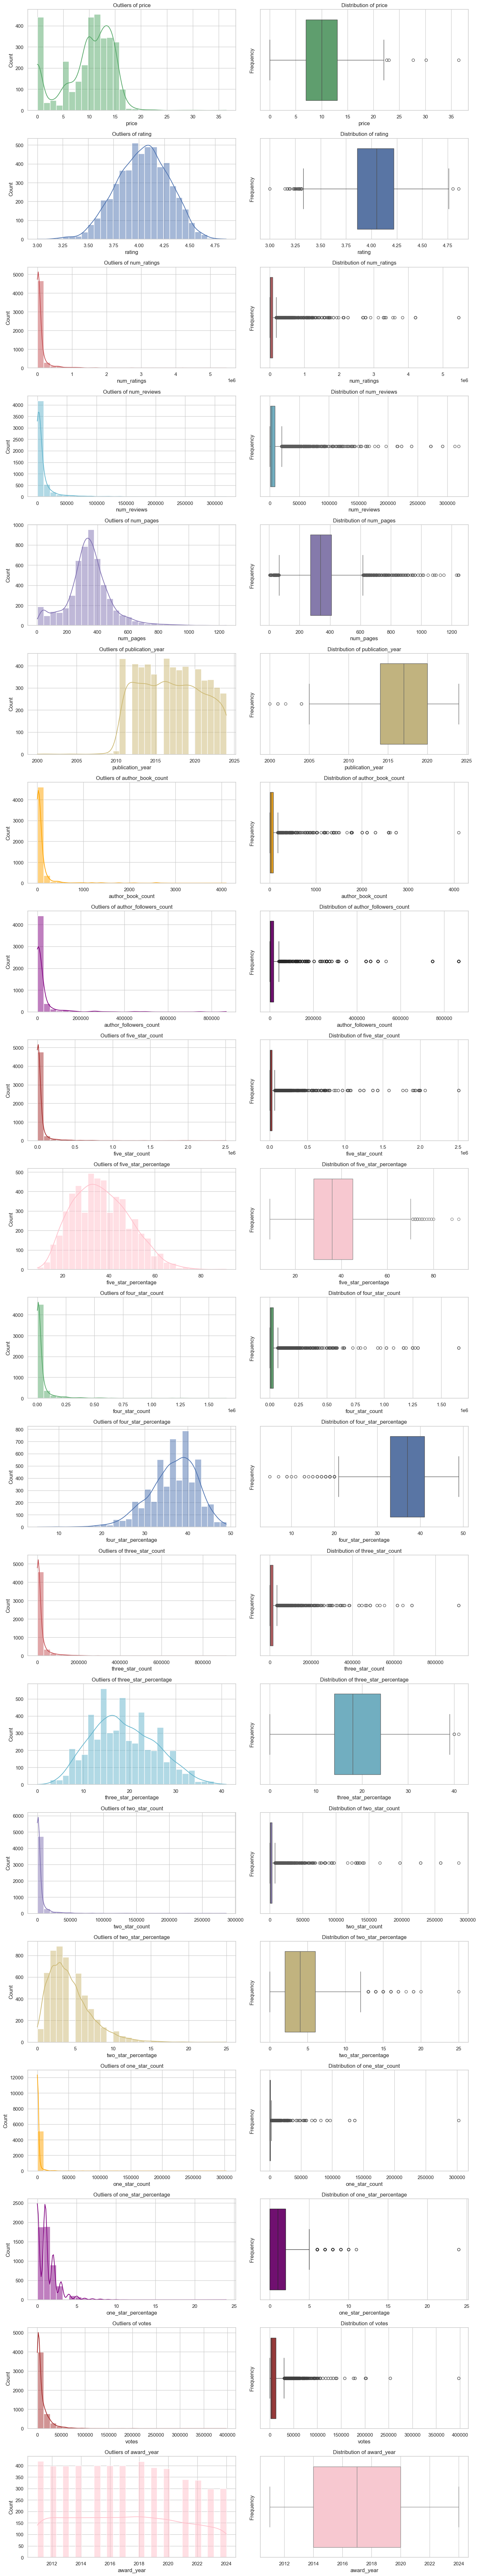

In [52]:
df_columns = df.columns
categorical_features = ['title', 'genres', 'category', 'author']
numerical_features = [col for col in df_columns if col not in categorical_features]

num_features = len(numerical_features)
colors = ['g', 'b', 'r', 'c', 'm', 'y', 'orange', 'purple', 'brown', 'pink']

print(f"\nNumerical Feature Distributions and Outliers")
fig, axes = plt.subplots(num_features, 2, figsize=(15, 4 * num_features))

for idx, col in enumerate(numerical_features):
    current_color = colors[idx % len(colors)]
    
    sns.boxplot(
        x=df[col], 
        color=current_color, 
        ax=axes[idx, 1]
    )

    axes[idx, 0].set_title(f'Outliers of {col}', fontsize=12)
    axes[idx, 0].set_xlabel('')
    
    
    sns.histplot(
        df[col], 
        bins=30, 
        kde=True, 
        color=current_color, 
        ax=axes[idx, 0]
    )
    
    axes[idx, 1].set_title(f'Distribution of {col}', fontsize=12)
    axes[idx, 1].set_xlabel(col)
    axes[idx, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Distribution & Central Tendency**

*   **Distribution Shape:**
    *   **Right-Skewed:** `num_ratings`, `num_reviews`, `votes`, `author_book_count`, `author_followers_count`.
    *   **Normal:** `rating` (centered around 4.0), `num_pages` (centered around 340).
    *   **Bimodal/Spiky:** `price` (spikes at 0 and common price points like 10 or 12).
*   **Central Tendency:**
    *   **Rating:** Mean 4.04, Median 4.05 (Very stable).
    *   **Num Ratings:** Mean 106k, Median 25k (Huge difference due to skew).
    *   **Pages:** Mean 342, Median 338.

**Range & Outliers**

*   **Minimums:**
    *   `price`: 0.00 (Bundle/Subscription).
    *   `num_ratings`: 10 (Very low for an award nominee, likely a data quirk or very niche).
    *   `num_pages`: 4 (Likely a short story or error).
*   **Maximums:**
    *   `num_ratings`: ~5.4 Million.
    *   `author_followers`: 868k.
    *   `author_book_count`: 4,105.
*   **Reasonable?** Yes, the extremes are genuine "Viral Hits" or have valid reasons behind them, but they are outliers that need Log Transformation.

**Data Quality**

*   **Missing Values:**
    *   `price`: ~38% missing.
    *   `num_pages`: ~0.3% missing.
    *   `author_followers_count`: ~0.1% missing.
*   **Impossible Values:** None found (no negative ages or prices).
*   **Placeholder Values:**
    *   `price = 0`: Represents a specific business model (Bundle/Promo), not a missing value.
    *   `price = NA`: Represents Subscription/Audiobook credits.

Missing Values Summary
                        Missing Count  Percentage (%)
price                            2031       38.444066
num_pages                          16        0.302858
author_followers_count              5        0.094643
------------------------------


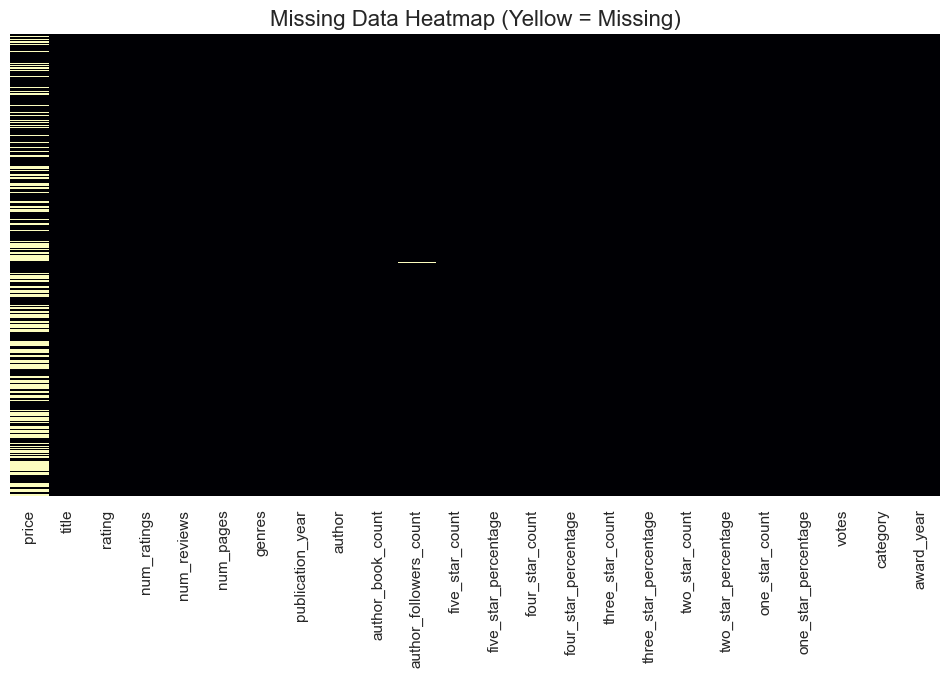

In [75]:
missing_count = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Percentage (%)': missing_pct
})

missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)

print("Missing Values Summary")
print(missing_df)
print("-" * 30)

plt.figure(figsize=(12, 6))
sns.heatmap(
    df.isnull(), 
    cbar=False, 
    cmap='magma', 
    yticklabels=False
)

plt.title('Missing Data Heatmap (Yellow = Missing)', fontsize=16)
plt.show()

**Overall Assessment**

*   **Missing Values Summary:**
    *   `price`: ~38% missing (2,031 rows).
    *   `num_pages`: < 0.3% missing (16 rows).
    *   `author_followers_count`: < 0.1% missing (5 rows).
*   **Patterns:**
    *   **Price:** The missing values are **not random**. The heatmap shows large, consistent chunks of missing data. This suggests a systematic reason (like the book format or sales model).
    *   **Others:** Missing values for pages and followers appear to be **random** and very rare.

**Per Column Strategy**

*   **1. Price**
    *   **Why is it missing?** These are likely books sold via **Subscription** (e.g., Kindle Unlimited, Audible) or **Bundles**, where a specific individual price is "Not Applicable."
    *   **Plan:** Do **not** remove or guess the average. Create a specific category or flag (e.g., `is_subscription` or `Price_Tier = 'Unknown'`).

*   **2. Num Pages**
    *   **Why is it missing?** Likely data entry errors or audio-only editions.
    *   **Plan:** Fill with the **Median** page count. 

*   **3. Author Followers**
    *   **Why is it missing?** Likely new or very niche authors.
    *   **Plan:** Fill with the **Median** (or 0).

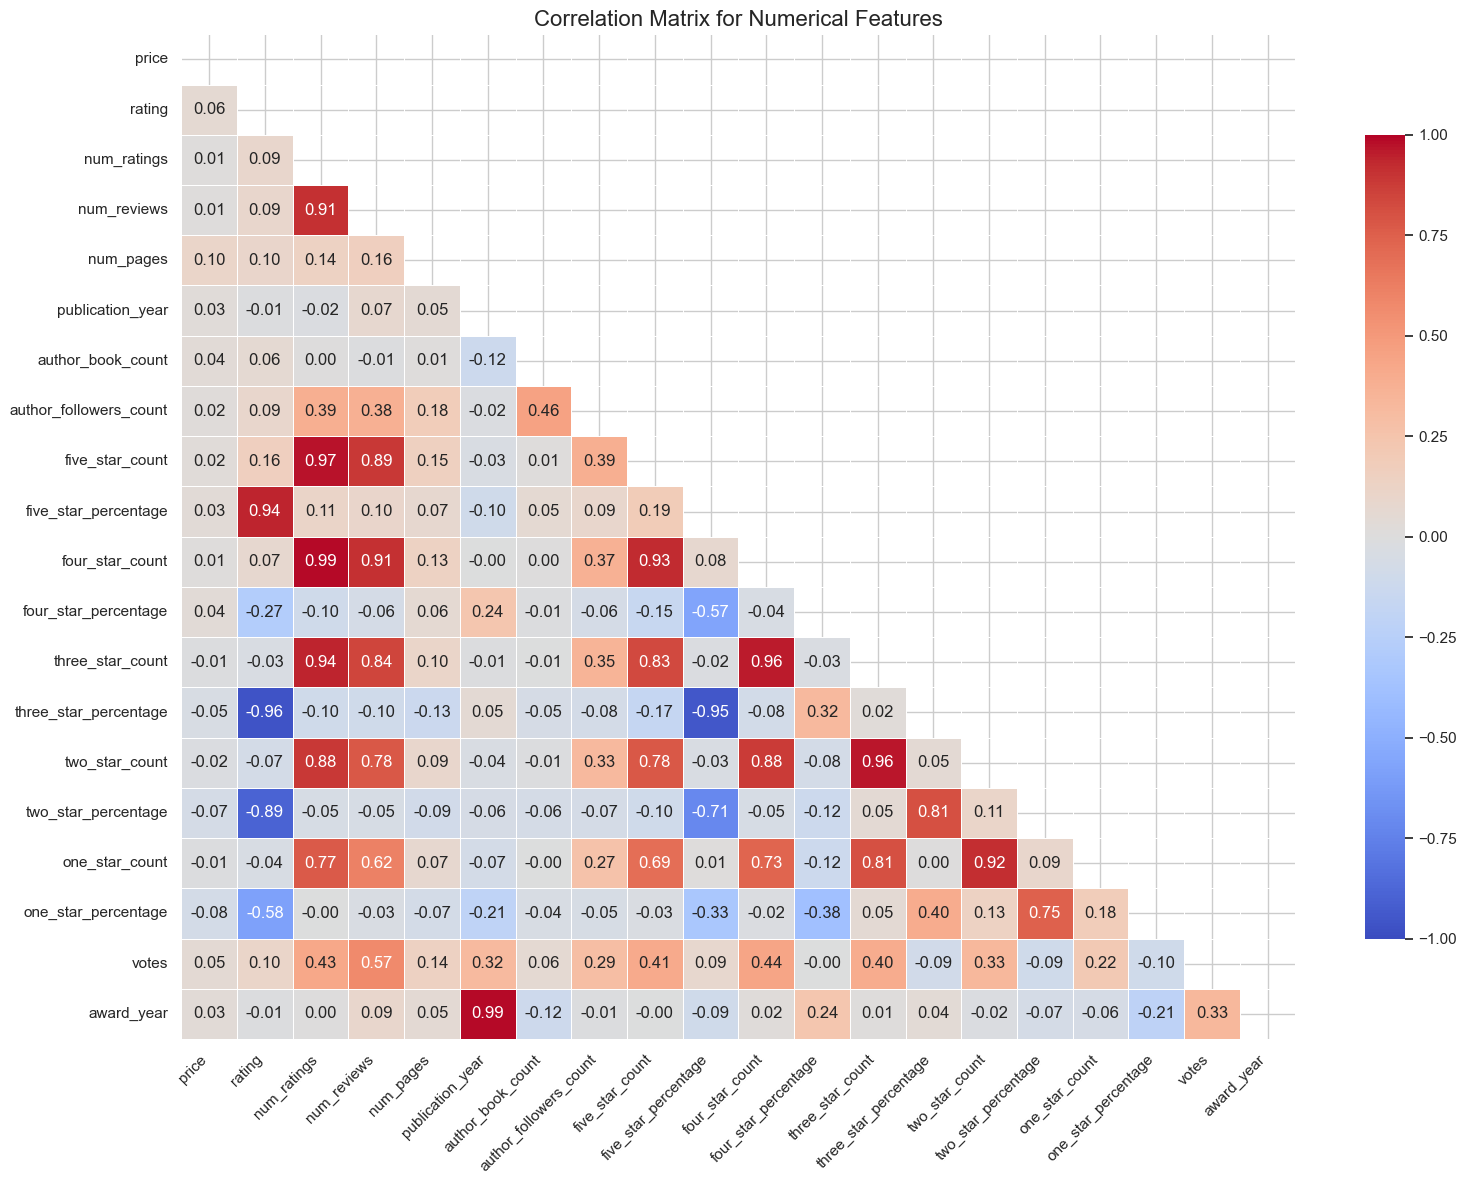

In [53]:
categorical_features = ['title', 'genres', 'category', 'author']
numerical_features = [col for col in df_columns if col not in categorical_features]

features_for_corr = numerical_features

plt.figure(figsize=(16, 12))

corr = df[features_for_corr].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr, 
    mask=mask,          
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    vmin=-1,            
    vmax=1, 
    linewidths=0.5,     
    cbar_kws={"shrink": 0.8} 
)

plt.title('Correlation Matrix for Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Relationships & Correlations**

*   **Strongly Correlated Pairs:**
    *   **Leakage:** `num_ratings`, `num_reviews`, `votes`, and all `star_counts` are highly correlated (> 0.90). This is expected (more ratings = more reviews).
    *   **Time:** `publication_year` and `award_year` are nearly perfectly correlated (0.99). This makes sense, books are usually nominated in the year they are published.
*   **Surprising Relationships:**
    *   **Reputation Impact:** `author_followers_count` has a moderate positive correlation with `num_ratings` (0.39). This is the **strongest valid predictor** so far.
    *   **Quality vs. Quantity:** The correlation between `rating` (Quality) and `num_ratings` (Reach) is very low (0.09), being highly rated does **not** guarantee being widely read.

**Summary**

*   **Key Observations:**
    1.  **High Engagement:** The average book has over 100,000 ratings, but the data is heavily skewed by a few viral books, however, there are still many niche books (less than 10,000 ratings).
    2.  **Quality vs. Quantity:** There is almost no correlation ($r=0.09$) between a book's Rating (Quality) and its Number of Ratings (Reach). Being highly rated does not guarantee being widely read.
    3.  **Pricing Strategies:** The high volume of books with `0` or `NA` prices suggests that **Subscription Models** and **Bundles** are an important distribution strategy for these popular books, rather than just traditional direct sales.
    4.  **Author Influence:** There is a noticeable positive relationship (Correlation ~0.39) between an author's **Follower Count** and the book's **Number of Ratings** (Reach). This suggests that an author's fan base is a key driver of visibility.
    5.  **Format:** "Audiobook" is the second most frequent tag in the entire dataset. This indicates that the **format** of consumption is a major characteristic of these award-nominated books, along with traditional  genres (like Fiction or Fantasy).

*   **Data Quality Issues:**
    1.  **Missing Prices:** About 38% of books have no price (`NA` or `0`). However, analysis suggests this represents **Books sold in Bundles** rather than missing data.
    2.  **Genre Formatting:** The `genres` column is a single string containing multiple tags separated by pipes (`|`), which cannot be used directly for analysis.

*   **Necessary Preprocessing:**
    1.  **Feature Engineering:** Convert `price` into categorical tiers (Subscription vs. Bundle vs. Retail) and split `genres` into binary flags (One-Hot Encoding).
    2.  **Transformation:** Apply **Log Transformation** to skewed features like `num_ratings` and `author_followers_count` to handle outliers.
    3.  **Cleaning:** Drop "Data Leakage" columns (like `votes` and `num_reviews`) that would cheat the predictive model.

*   **Interesting Patterns:**
    *   **Author Reputation:** There is a notable relationship between an Author's Follower count and the Book's Reach, suggesting reputation drives sales more than quality.
    *   **Hidden Complexity:** Standard features like `price` and `rating` show very weak correlations with success on their own. A stronger feature may be hidden inside complex unstructured columns like `genres`  or requires interpreting missing values like different pricing strategies.

**Red Flags**

*   **Serious Data Quality Concerns:**
    *   **Data Leakage:** Columns like `votes` and `num_reviews` are perfectly correlated with the target. If we don't drop them, the model will be useless.

*   **Limitations:**
    *   **Popularity Bias:** This dataset only contains award nominees ("Good" books). We cannot train a model to detect "Bad" books because there are no failures in the dataset.
    *   **Recency Bias:** Books from 2024 have fewer total ratings than books from 2011 simply because they have been out for less time.

### 3. Question Formulation

## Question 1: Price and Popularity
**1. The Question**
*   Do books in **Subscription** services or **Bundles** get more attention than normal paid books? 
*   Is there a specific price range that works best?

**2. Motivation & Benefits**
*   **Why investigate?** Pricing is easy to change. Authors and publishers need to know the best price to set.
*   **Insights provided:** We will find out if "Subscription" or selling books in a bundle is the best way to get famous, or if a higher price makes people think a book is better quality.
*   **Who cares?** Authors and Publishers trying to sell more books.
*   **Real-world problem:** Deciding if a new book should be sold directly or put on a subscription platform to get more readers.

---

## Question 2: Author Fame vs. Book Quality
**1. The Question**
*   Does an **Author's Fame** (Followers) actually make a book successful?
*   Does having a huge audience lead to better ratings, or does it just lead to *more* ratings (reach)? Do popular authors get judged more harshly?

**2. Motivation & Benefits**
*   **Why investigate?** We want to know if a "Best Seller" is actually a "Good Book," or just a book by a famous person.
*   **Insights provided:** This separates the author's brand from the book's actual quality.
*   **Who cares?** Editors deciding which authors to sign.
*   **Real-world problem:** Should a publisher pay a lot of money for a famous author, or invest in a new author with a great story?

---

## Question 3: Changing Habits (Audiobooks & Genres)
**1. The Question**
*   How does **Audiobooks** affect book length, and is it an important driver for a book's success? 
*   Which **Genres, Genre Combinations** are most popular? Is there a benefit to combining multiple genres?

**2. Motivation & Benefits**
*   **Why investigate?** The market changes fast. We need to know if Audiobooks are now "required" for a book to succeed.
*   **Insights provided:** Finding out if Audiobooks are saving long novels, and identifying which mix of genres creates a viral hit.
*   **Who cares?** Authors planning their next book format and genre.
*   **Real-world problem:** An author deciding whether to write a short story or a long novel, and whether to pay for an audiobook version.

---

## Question 4: Predicting a book's reach
**1. The Question**
*   Can we build a model to predict how **Popular** (`num_ratings`) a book will be before it is released?
*   Can the model tell the difference between a **Small Success** and a **Global Hit**?

**2. Motivation & Benefits**
*   **Why investigate?** Predicting popularity helps estimate sales and revenue.
*   **Insights provided:** It proves which factors (Price, Genre, Author) are the most important for success.
*   **Who cares?** Bookstores deciding how many copies to buy.
*   **Real-world problem:** Risk management. If the model says a book will be a "Global Hit" the publisher can spend more on ads. If it says "Small Success," they can save money.

**3. Machine Learning Setup**

*   **Problem Setup:**
    *   This is a **Regression** problem. The aim is to predict a continuous value: the number of ratings.
    *   **The Challenge:** The target variable is highly skewed (some books have 10 ratings, others have 5 million). Many trends (like genres and pricing strategies) are currently hidden 
    *   **Constraint:** because the aim is to predict a book's num rating before it is published, all data that is only available *after* a book is published (e.g., average star rating, number of reviews, award votes) has to be removed.

*   **Data Split:**
    *   The dataset is split into three parts:
        *   **Training (70%):** Used to teach the model.
        *   **Validation (15%):** Used to tune the model settings (Hyperparameters).
        *   **Test (15%):** Used to evaluate how well the model performs on new books.

*   **Models Chosen:**
    1.  **OLS (Ordinary Least Squares):** A standard Linear Regression to set a baseline.
    2.  **Ridge Regression (L2):** A regularized model that handles correlated features well (useful for overlapping genres).
    3.  **Lasso Regression (L1):** A model that performs feature selection by ignoring useless columns.

*   **Evaluation Metrics:**
    *   **RMSE (Root Mean Squared Error):** Measures the mathematical error on the Log scale. Lower is better.
    *   **R² (R-Squared):** Measures how much of the variance in popularity our model can explain. (0 to 1).
    *   **MAE (Mean Absolute Error):** To understand the error in a business context (e.g., "The model is off by 70,000 ratings on average").